Test Libraries

In [1]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import os


generate OpenVinoModel

In [ ]:
from ultralytics import YOLO

# Load your custom or pretrained PyTorch model
model = YOLO("../ball-detector/models/vbn11.pt")  # or "yolo11n.pt"

# Export to OpenVINO format
model.export(
    format="openvino", 
    half=True,         # This is the key for FP16
    imgsz=640,         # Match your training image size
    dynamic=False,     # Set to True only if you need variable input sizes
    batch=1
)

WARNING Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.


TypeError: model='../../models/ball_detection/vbn11_openvino_model_1' should be a *.pt PyTorch model to run this method, but is a different format. PyTorch models can train, val, predict and export, i.e. 'model.train(data=...)', but exported formats like ONNX, TensorRT etc. only support 'predict' and 'val' modes, i.e. 'yolo predict model=yolo11n.onnx'.
To run CUDA or MPS inference please pass the device argument directly in your inference command, i.e. 'model.predict(source=..., device=0)'

test openVino model

In [ ]:
import openvino as ov

core = ov.Core()
devices = core.available_devices

print(f"Available devices: {devices}")
if "GPU" in devices:
    print("✅ Success! Your Intel Iris GPU is detected.")
else:
    print("❌ Iris GPU not detected. Only CPU is available.")


image 1/1 C:\Users\morde\Pictures\Screenshots\Screenshot 2026-01-12 212906.png: 640x480 5 persons, 1 sports ball, 63.6ms
Speed: 1.7ms preprocess, 63.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


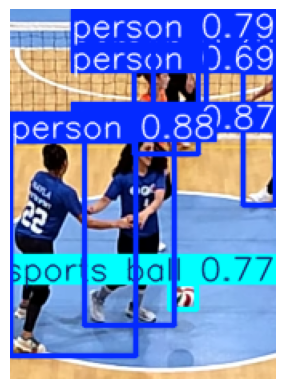

In [15]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# 1. Point to the FOLDER containing the .xml and .bin files
# Ensure 'vbn11_openvino_model' contains your exported files
model_path = r'C:\Users\morde\Desktop\projects\volleyball_cv_project\models\ball_detection\vbn11_openvino_model_1'
model = YOLO('yolo11n', task="detect")

path = r"C:\Users\morde\Pictures\Screenshots\Screenshot 2026-01-12 212906.png"

results = model.predict(source=path, device="cpu", imgsz=640)

# Display results
for r in results:
    annotated_frame = r.plot()
    annotated_frame_rgb = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
    plt.imshow(annotated_frame_rgb)
    plt.axis("off")
    plt.show()

In [ ]:
import openvino as ov
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

# 1. Setup OpenVINO
core = ov.Core()
model_xml = r'C:\Users\morde\Desktop\projects\test vb cv\my_code\ball-detector\models\vbn11_openvino_model\vbn11.xml'
compiled_model = core.compile_model(model_xml, "GPU")
infer_request = compiled_model.create_infer_request()

# 2. Prepare Image
path = r"C:\Users\morde\Desktop\projects\test vb cv\my_code\videos\test_img.png"
original_img = cv2.imread(path)
h_orig, w_orig = original_img.shape[:2]

# Resize and normalize for YOLO
input_img = cv2.resize(original_img, (640, 640))
input_tensor = input_img.transpose(2, 0, 1)  # HWC to CHW
input_tensor = np.expand_dims(input_tensor, 0).astype(np.float32) / 255.0

# 3. Run Inference
start = time.time()
output = compiled_model(input_tensor)[compiled_model.output(0)]
end = time.time()
print(f"Iris GPU Inference Time: {end - start:.4f} seconds")

# 4. Post-Process (Parse YOLO Output)
# Output shape is typically [1, 5, 8400] for 1 class (x, y, w, h, score)
predictions = np.squeeze(output).T
scores = predictions[:, 4]
mask = scores > 0.1  # Confidence threshold
filtered_predictions = predictions[mask]

boxes = filtered_predictions[:, :4]
confidences = filtered_predictions[:, 4]

# Convert YOLO format (center_x, center_y, width, height) to (x1, y1, x2, y2)
# and scale back to original image size
for i in range(len(boxes)):
    x, y, w, h = boxes[i]
    boxes[i][0] = (x - w / 2) * (w_orig / 640)
    boxes[i][1] = (y - h / 2) * (h_orig / 640)
    boxes[i][2] = w * (w_orig / 640)
    boxes[i][3] = h * (h_orig / 640)

# Apply NMS (Non-Maximum Suppression) to remove overlapping boxes
indices = cv2.dnn.NMSBoxes(boxes.tolist(), confidences.tolist(), score_threshold=0.1, nms_threshold=0.45)

# 5. Draw and Plot
annotated_frame = original_img.copy()
if len(indices) > 0:
    for i in indices.flatten():
        x, y, w, h = boxes[i].astype(int)
        # Draw the rectangle
        cv2.rectangle(annotated_frame, (x, y), (x + w, y + h), (0, 255, 0), 3)
        # Draw Label
        label = f"Ball: {confidences[i]:.2f}"
        cv2.putText(annotated_frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# Convert BGR to RGB for Matplotlib
annotated_frame_rgb = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 8))
plt.imshow(annotated_frame_rgb)
plt.title(f"Inference: {end - start:.4f}s")
plt.axis("off")
plt.show()

In [ ]:
for r in results:
    # Get the image with boxes (returns BGR numpy array)
    annotated_frame = r.plot()
    
    # Convert BGR to RGB for correct colors in Matplotlib
    annotated_frame_rgb = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    plt.imshow(annotated_frame_rgb)
    plt.axis("off")  # Hide x and y axis
    plt.show()

Run Model on Video and extract data

In [48]:
#1 batch
import cv2
import time
import csv
from ultralytics import YOLO

# 1. Load the OpenVINO model
# Ensure the path points to the folder containing the .xml and .bin files
model_path = r'..\ball-detector\models\vbn11_openvino_model'
model = YOLO(model_path, task="detect")

# 2. Setup Video Input and CSV Output
video_path = r"C:\Users\morde\Desktop\projects\volleyball cv\data\input_videos\game7.mp4"
output_csv = "game7_inference_results_v11.csv"

cap = cv2.VideoCapture(video_path)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Prepare CSV file
with open(output_csv, mode='w', newline='') as f:
    writer = csv.writer(f)
    # Header: frame_id, class, confidence, x_min, y_min, x_max, y_max
    writer.writerow(['frame', 'class', 'conf', 'x1', 'y1', 'x2', 'y2'])

    frame_count = 0
    print(f"Starting inference on {total_frames} frames using CPU...")

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # 3. Run Inference
        start_time = time.time()
        
        # device="cpu" is redundant if the model is already OpenVINO, 
        # but good for clarity. stream=True is more memory efficient.
        results = model.predict(
            source=frame, 
            device="intel:gpu", 
            conf=0.1, 
            iou=0.45, 
            imgsz=640, 
            verbose=False,
            stream=False # Set to False here to handle single frame objects easily
        )
        
        end_time = time.time()

        # 4. Calculate and Print FPS
        inference_time = end_time - start_time
        fps = 1 / inference_time
        print(f"Frame {frame_count}/{total_frames} | FPS: {fps:.2f}", end="\r")

        # 5. Process Results and Save to CSV
        for result in results:
            boxes = result.boxes
            for box in boxes:
                # Extract coordinates and info
                x1, y1, x2, y2 = box.xyxy[0].tolist()
                conf = box.conf[0].item()
                cls = int(box.cls[0].item())
                
                # Write row to CSV
                writer.writerow([frame_count, cls, f"{conf:.4f}", int(x1), int(y1), int(x2), int(y2)])

        frame_count += 1

cap.release()
print(f"\nProcessing complete. Results saved to {output_csv}")

Starting inference on 141928 frames using CPU...
Loading ..\ball-detector\models\vbn11_openvino_model for OpenVINO inference...
Using OpenVINO LATENCY mode for batch=1 inference on GPU.0...
Frame 141927/141928 | FPS: 47.547
Processing complete. Results saved to game7_inference_results_v11.csv


In [ ]:
import pandas as pd
import numpy as np

def track_with_physics(csv_input, max_distance=200, max_gap=30):
    # Load detections and calculate centers
    df = pd.read_csv(csv_input).sort_values('frame')
    df['cx'] = (df['x1'] + df['x2']) / 2
    df['cy'] = (df['y1'] + df['y2']) / 2
    
    # Initialize output columns
    df['track_id'] = -1
    df['vx'] = 0.0
    df['vy'] = 0.0
    df['speed_px_frame'] = 0.0
    df['direction_deg'] = 0.0
    
    next_id = 0
    active_tracks = {} # Store: {id: {'last_f': frame, 'last_pos': (cx, cy)}}
    
    for f in sorted(df['frame'].unique()):
        frame_indices = df[df['frame'] == f].index.tolist()
        assigned_indices = []
        
        # Sort active tracks by most recent to maintain continuity
        sorted_tids = sorted(active_tracks.keys(), key=lambda x: active_tracks[x]['last_f'], reverse=True)
        
        for tid in sorted_tids:
            last_info = active_tracks[tid]
            
            # Close tracks that haven't been seen for too long
            if f - last_info['last_f'] > max_gap:
                del active_tracks[tid]
                continue
            
            # Find the best match in the current frame
            best_dist, best_idx = max_distance, -1
            for idx in frame_indices:
                if idx in assigned_indices: continue
                
                dist = np.sqrt((last_info['last_pos'][0] - df.loc[idx, 'cx'])**2 + 
                               (last_info['last_pos'][1] - df.loc[idx, 'cy'])**2)
                
                if dist < best_dist:
                    best_dist, best_idx = dist, idx
            
            if best_idx != -1:
                # --- Physics Calculations ---
                dt = f - last_info['last_f'] # Number of frames since last seen
                dx = df.loc[best_idx, 'cx'] - last_info['last_pos'][0]
                dy = df.loc[best_idx, 'cy'] - last_info['last_pos'][1]
                
                vx, vy = dx / dt, dy / dt
                speed = np.sqrt(vx**2 + vy**2)
                # Angle in degrees (-180 to 180). 0 is right, 90 is down, -90 is up.
                angle = np.degrees(np.arctan2(dy, dx))
                
                # Update DataFrame
                df.at[best_idx, 'track_id'] = tid
                df.at[best_idx, 'vx'] = vx
                df.at[best_idx, 'vy'] = vy
                df.at[best_idx, 'speed_px_frame'] = speed
                df.at[best_idx, 'direction_deg'] = angle
                
                # Update Tracker State
                active_tracks[tid] = {'last_f': f, 'last_pos': (df.loc[best_idx, 'cx'], df.loc[best_idx, 'cy'])}
                assigned_indices.append(best_idx)
        
        # Initialize new tracks for unassigned detections
        for idx in frame_indices:
            if idx not in assigned_indices:
                df.at[idx, 'track_id'] = next_id
                active_tracks[next_id] = {'last_f': f, 'last_pos': (df.loc[idx, 'cx'], df.loc[idx, 'cy'])}
                next_id += 1
                
    return df



In [57]:
import pandas as pd
import numpy as np

def track_with_physics_predictive_2(csv_input, min_radius=50, max_radius=250, max_gap=15, velocity_margin=0.5):
    df = pd.read_csv(csv_input).sort_values('frame')
    df['cx'] = (df['x1'] + df['x2']) / 2
    df['cy'] = (df['y1'] + df['y2']) / 2
    
    df['track_id'] = -1
    df['vx'] = 0.0
    df['vy'] = 0.0
    df['speed_px_frame'] = 0.0
    df['direction_deg'] = 0.0
    
    next_id = 0
    active_tracks = {} 
    
    for f in sorted(df['frame'].unique()):
        frame_indices = df[df['frame'] == f].index.tolist()
        assigned_indices = []
        
        sorted_tids = sorted(active_tracks.keys(), key=lambda x: active_tracks[x]['last_f'], reverse=True)
        
        for tid in sorted_tids:
            last_info = active_tracks[tid]
            
            # --- FIX 3: SKIP STATIC TRACKS ---
            # If this track is already flagged as static, we don't try to 
            # "pull" new detections into it anymore.
            if last_info.get('is_static', False):
                continue

            dt = f - last_info['last_f']
            if dt > max_gap:
                del active_tracks[tid]
                continue
            
            # 1. PREDICT position
            curr_vx, curr_vy = last_info.get('vx', 0), last_info.get('vy', 0)
            curr_speed = last_info.get('speed', 0)
            
            pred_x = last_info['last_pos'][0] + (curr_vx * dt)
            pred_y = last_info['last_pos'][1] + (curr_vy * dt)
            
            # 2. DYNAMIC SEARCH RANGE
            dynamic_threshold = min(min_radius + (3*curr_speed * dt * velocity_margin), max_radius)
            
            best_dist, best_idx = dynamic_threshold, -1
            for idx in frame_indices:
                if idx in assigned_indices: continue
                
                dist = np.sqrt((pred_x - df.loc[idx, 'cx'])**2 + (pred_y - df.loc[idx, 'cy'])**2)
                if dist < best_dist:
                    best_dist, best_idx = dist, idx
            
            # 3. Update track
            if best_idx != -1:
                new_pos = (df.loc[best_idx, 'cx'], df.loc[best_idx, 'cy'])
                
                # --- STATIONARY LOGIC ---
                # Calculate distance from the literal last recorded position
                displacement = np.sqrt((new_pos[0] - last_info['last_pos'][0])**2 + 
                                       (new_pos[1] - last_info['last_pos'][1])**2)
                
                # If movement is negligible (e.g., < 3 pixels), increment counter
                if displacement < 3:
                    stationary_count = last_info.get('stationary_count', 0) + 1
                else:
                    stationary_count = 0 # Reset if it actually moves
                
                # Flag as static if threshold reached
                is_static = stationary_count >= 30
                
                # Calculate physics
                dx, dy = new_pos[0] - last_info['last_pos'][0], new_pos[1] - last_info['last_pos'][1]
                vx, vy = dx / dt, dy / dt
                speed = np.sqrt(vx**2 + vy**2)
                
                df.at[best_idx, 'track_id'] = tid
                df.at[best_idx, 'vx'], df.at[best_idx, 'vy'] = vx, vy
                df.at[best_idx, 'speed_px_frame'] = speed
                
                active_tracks[tid] = {
                    'last_f': f, 
                    'last_pos': new_pos,
                    'vx': vx, 'vy': vy, 'speed': speed,
                    'stationary_count': stationary_count,
                    'is_static': is_static
                }
                assigned_indices.append(best_idx)
        
        # New track initialization
        for idx in frame_indices:
            if idx not in assigned_indices:
                df.at[idx, 'track_id'] = next_id
                active_tracks[next_id] = {
                    'last_f': f, 
                    'last_pos': (df.loc[idx, 'cx'], df.loc[idx, 'cy']),
                    'vx': 0.0, 'vy': 0.0, 'speed': 0.0,
                    'stationary_count': 0,
                    'is_static': False
                }
                next_id += 1
                
    return df

In [42]:
import pandas as pd
import numpy as np

def track_with_physics_predictive(csv_input, min_radius=50, max_radius=250, max_gap=15, velocity_margin=0.5):
    """
    Args:
        min_radius: The minimum search area (pixels) even if the ball is stationary.
        max_radius: The absolute maximum distance to search (safety cap).
        max_gap: Max frames to keep a track alive without a detection.
        velocity_margin: How much "extra" space to give based on current speed. 
                         0.5 means search radius grows by 50% of the distance traveled per frame.
    """
    df = pd.read_csv(csv_input).sort_values('frame')
    df['cx'] = (df['x1'] + df['x2']) / 2
    df['cy'] = (df['y1'] + df['y2']) / 2
    
    df['track_id'] = -1
    df['vx'] = 0.0
    df['vy'] = 0.0
    df['speed_px_frame'] = 0.0
    df['direction_deg'] = 0.0
    
    next_id = 0
    active_tracks = {} 
    
    for f in sorted(df['frame'].unique()):
        frame_indices = df[df['frame'] == f].index.tolist()
        assigned_indices = []
        
        sorted_tids = sorted(active_tracks.keys(), key=lambda x: active_tracks[x]['last_f'], reverse=True)
        
        for tid in sorted_tids:
            last_info = active_tracks[tid]
            dt = f - last_info['last_f']
            
            if dt > max_gap:
                del active_tracks[tid]
                continue
            
            # 1. PREDICT position
            curr_vx = last_info.get('vx', 0)
            curr_vy = last_info.get('vy', 0)
            curr_speed = last_info.get('speed', 0)
            
            pred_x = last_info['last_pos'][0] + (curr_vx * dt)
            pred_y = last_info['last_pos'][1] + (curr_vy * dt)
            
            # 2. DYNAMIC SEARCH RANGE
            # The radius grows based on speed and time elapsed (dt)
            # Formula: Base Radius + (Potential deviation based on speed)
            dynamic_threshold = min_radius + (3*curr_speed * dt * velocity_margin)
            dynamic_threshold = min(dynamic_threshold, max_radius) # Cap it
            
            if(dynamic_threshold > max_radius):
                print("consider increasing max_radius because of frame ", f)
            best_dist, best_idx = dynamic_threshold, -1
            
            for idx in frame_indices:
                if idx in assigned_indices: continue
                
                dist = np.sqrt((pred_x - df.loc[idx, 'cx'])**2 + 
                               (pred_y - df.loc[idx, 'cy'])**2)
                
                if dist < best_dist:
                    best_dist, best_idx = dist, idx
            
            # 3. Update track
            if best_idx != -1:
                dx = df.loc[best_idx, 'cx'] - last_info['last_pos'][0]
                dy = df.loc[best_idx, 'cy'] - last_info['last_pos'][1]
                
                vx, vy = dx / dt, dy / dt
                speed = np.sqrt(vx**2 + vy**2)
                angle = np.degrees(np.arctan2(dy, dx))
                
                df.at[best_idx, 'track_id'] = tid
                df.at[best_idx, 'vx'] = vx
                df.at[best_idx, 'vy'] = vy
                df.at[best_idx, 'speed_px_frame'] = speed
                df.at[best_idx, 'direction_deg'] = angle
                
                active_tracks[tid] = {
                    'last_f': f, 
                    'last_pos': (df.loc[best_idx, 'cx'], df.loc[best_idx, 'cy']),
                    'vx': vx,
                    'vy': vy,
                    'speed': speed
                }
                assigned_indices.append(best_idx)
        
        for idx in frame_indices:
            if idx not in assigned_indices:
                df.at[idx, 'track_id'] = next_id
                active_tracks[next_id] = {
                    'last_f': f, 
                    'last_pos': (df.loc[idx, 'cx'], df.loc[idx, 'cy']),
                    'vx': 0.0,
                    'vy': 0.0,
                    'speed': 0.0
                }
                next_id += 1
                
    return df

In [ ]:
# Apply to your file
results = track_with_physics_predictive_2('game7_inference_results_v11.csv')
# Keep only the main ball track (the one with the most detections)
ball_id = results['track_id'].value_counts().idxmax()

ball_data = results[results['track_id'] == ball_id]

results.to_csv('game7_full_physics_tracking.csv', index=False)

In [59]:
ball_id

8069

In [ ]:
#n batch
import cv2
import time
import csv
from ultralytics import YOLO

# 1. Load the OpenVINO model
model_path = r'..\ball-detector\models\vbn3_openvino_model_16'
model = YOLO(model_path, task="detect")

# 2. Setup Video Input and CSV Output
video_path = r"C:\Users\morde\Desktop\projects\volleyball cv\data\input_videos\game1_full.mp4"
output_csv = "game5_set1_inference_results64.csv"
BATCH_SIZE = 16

cap = cv2.VideoCapture(video_path)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

with open(output_csv, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['frame', 'class', 'conf', 'x1', 'y1', 'x2', 'y2'])

    frame_count = 0
    print(f"Starting inference on {total_frames} frames using batch size {BATCH_SIZE}...")

    while cap.isOpened():
        batch_frames = []
        batch_indices = []

        # Collect frames for the batch
        for i in range(BATCH_SIZE):
            ret, frame = cap.read()
            if not ret:
                break
            batch_frames.append(frame)
            batch_indices.append(frame_count)
            frame_count += 1

        if not batch_frames:
            break

        # 3. Run Inference on the batch
        start_time = time.time()
        
        # Passing a list of images triggers batch inference
        results = model.predict(
            source=batch_frames, 
            device="cpu", 
            conf=0.1, 
            iou=0.45, 
            imgsz=640, 
            verbose=False,
            stream=False 
        )
        
        end_time = time.time()

        # 4. Calculate FPS (averaged over the batch)
        inference_time = end_time - start_time
        fps = len(batch_frames) / inference_time
        print(f"Processed up to frame {frame_count}/{total_frames} | Batch FPS: {fps:.2f}", end="\r")

        # 5. Process Results
        # 'results' is a list corresponding to the images in 'batch_frames'
        for i, result in enumerate(results):
            current_frame_id = batch_indices[i]
            boxes = result.boxes
            for box in boxes:
                x1, y1, x2, y2 = box.xyxy[0].tolist()
                conf = box.conf[0].item()
                cls = int(box.cls[0].item())
                
                writer.writerow([current_frame_id, cls, f"{conf:.4f}", int(x1), int(y1), int(x2), int(y2)])

cap.release()
print(f"\nProcessing complete. Results saved to {output_csv}")

Save results

In [50]:
import cv2
import pandas as pd
from tqdm import tqdm

def overlay_results(video_path, csv_path, output_path):
    # 1. Load the detection results
    # Matching the headers from our previous CSV output: frame, class, conf, x1, y1, x2, y2
    df = pd.read_csv(csv_path)
    
    # Calculate the center point (x, y) from the bounding box
    df['center_x'] = (df['x1'] + df['x2']) / 2
    df['center_y'] = (df['y1'] + df['y2']) / 2

    # Create lookup: {frame_idx: [(center_x, center_y), ...]}
    detections = df.groupby('frame').apply(
        lambda x: list(zip(x['center_x'], x['center_y']))
    ).to_dict()

    # 2. Open the video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Define codec and output object (using 'mp4v' or 'avc1')
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    print(f"Applying overlay to {total_frames} frames...")

    # 3. Processing Loop
    for frame_idx in tqdm(range(total_frames)):
        ret, frame = cap.read()
        if not ret:
            break

        # Check if there are detections for the current frame
        if frame_idx in detections:
            for x, y in detections[frame_idx]:
                center = (int(round(x)), int(round(y)))
                
                # Draw outer circle (Yellow) - good for visibility against court floor
                cv2.circle(frame, center, 12, (0, 255, 255), 2)  
                # Draw inner dot (Red) - pinpoints the exact center
                cv2.circle(frame, center, 3, (0, 0, 255), -1)    
                
                # Label positioning: slightly offset so it doesn't cover the ball
                cv2.putText(frame, "Ball", (center[0] + 15, center[1] - 10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

        # Write frame to video
        out.write(frame)

    # Cleanup
    cap.release()
    out.release()
    print(f"\nProcessing complete. Saved to: {output_path}")

# --- Execution ---
# overlay_results("input_video.mp4", "inference_results.csv", "annotated_volleyball.mp4")

In [54]:
import cv2
import pandas as pd
from tqdm import tqdm

def overlay_results(video_path, csv_path, output_path):
    # 1. Load the detection results with physics data
    df = pd.read_csv(csv_path)
    
    # We already have 'cx' and 'cy' from the previous tracking step. 
    # If not, we calculate them:
    if 'cx' not in df.columns:
        df['cx'] = (df['x1'] + df['x2']) / 2
        df['cy'] = (df['y1'] + df['y2']) / 2

    # Create lookup: {frame_idx: [list of detection records]}
    # We store the whole record to access track_id and speed
    detections = df.groupby('frame').apply(lambda x: x.to_dict('records')).to_dict()

    # 2. Open the video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return

    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    print(f"Applying physics overlay to {total_frames} frames...")

    # 3. Processing Loop
    for frame_idx in tqdm(range(total_frames)):
        ret, frame = cap.read()
        if not ret:
            break

        # Check if there are tracked objects for the current frame
        if frame_idx in detections:
            for det in detections[frame_idx]:
                # Extract coordinates and physics
                center = (int(round(det['cx'])), int(round(det['cy'])))
                track_id = int(det['track_id'])
                speed = det['speed_px_frame']
                
                # Draw Visuals
                # Outer circle - color coded by track ID (optional, but helps distinguish objects)
                color = (0, 255, 255) # Yellow
                cv2.circle(frame, center, 15, color, 2)  
                cv2.circle(frame, center, 3, (0, 0, 255), -1) # Red center dot
                
                # --- Dynamic Labels ---
                # Label 1: Track ID
                label_id = f"ID: {track_id}"
                cv2.putText(frame, label_id, (center[0] + 20, center[1] - 15), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                
                # Label 2: Speed (only if speed > 0)
                if speed > 0:
                    label_speed = f"{speed:.1f} px/f"
                    cv2.putText(frame, label_speed, (center[0] + 20, center[1] + 5), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)

        out.write(frame)

    cap.release()
    out.release()
    print(f"\nProcessing complete. Saved to: {output_path}")

# --- Execution ---
# overlay_results("input_video.mp4", "volleyball_physics_tracking.csv", "physics_annotated.mp4")

In [55]:
overlay_results(r'C:\Users\morde\Desktop\projects\volleyball cv\data\input_videos\game7.mp4', '../ball-detector/game7_full_physics_tracking.csv', 'game7_physics_annotated.mp4')

C:\Users\morde\AppData\Local\Temp\ipykernel_22484\3234621163.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  detections = df.groupby('frame').apply(lambda x: x.to_dict('records')).to_dict()


Applying physics overlay to 141928 frames...


100%|██████████| 141928/141928 [1:05:44<00:00, 35.98it/s]



Processing complete. Saved to: game7_physics_annotated.mp4


In [ ]:
import cv2
import pandas as pd
import os
from tqdm import tqdm

# 1. Configuration
video_path = "../videos/game2_set1.mp4"
csv_path = "game2_set1_inference_results.csv"  # The file created in Step 1
output_folder = "game2-set-1-hard-data"
target_class_id = 0  # YOLO usually exports 'ball' as class 0

# Max number of EVEN frames missing to be considered a flicker
gap_threshold_frames = 5

os.makedirs(output_folder, exist_ok=True)

# 2. Load and Pre-process Data
df = pd.read_csv(csv_path) 
video_name = os.path.splitext(os.path.basename(video_path))[0]

# Ensure column names match our previous script: 'frame', 'class'
# We filter for the ball and get unique frame numbers where it WAS detected
detected_frames = sorted(
    df[df['class'] == target_class_id]['frame'].unique()
)

# 3. Identify gaps (flickers)
hard_frame_indices = []

print("Analyzing detection gaps...")
for i in range(len(detected_frames) - 1):
    current_f = detected_frames[i]
    next_f = detected_frames[i + 1]

    gap_size = next_f - current_f

    # Logic for Even-Frame Inference:
    # If gap == 2, no frames were missed (10 -> 12).
    # If gap > 2 and within threshold, we missed some frames.
    if 2 < gap_size <= (gap_threshold_frames + 1) * 2:
        # Generate the list of missed EVEN frames
        missing_even_frames = list(range(current_f + 2, next_f, 2))

        if missing_even_frames:
            # Pick the middle frame of the gap to capture the 'hardest' case
            chosen_frame = missing_even_frames[len(missing_even_frames) // 2]
            hard_frame_indices.append(chosen_frame)

# Remove duplicates if any
hard_frame_indices = sorted(list(set(hard_frame_indices)))
print(f"Found {len(hard_frame_indices)} missed detections to extract.")

# 4. Extract Frames from Video
cap = cv2.VideoCapture(video_path)
extracted_count = 0

print(f"Extracting frames to {output_folder}...")
for f_idx in tqdm(hard_frame_indices):
    # Seek to the specific frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, f_idx) 
    success, frame = cap.read()

    if success:
        # Save as JPG for labeling (e.g., in CVAT or LabelImg)
        file_name = f"{video_name}_frame_{f_idx}.jpg"
        save_path = os.path.join(output_folder, file_name)
        cv2.imwrite(save_path, frame)
        extracted_count += 1
    else:
        print(f"Warning: Could not read frame {f_idx}")

cap.release()
print(f"Successfully saved {extracted_count} 'hard' images to '{output_folder}'")

delete odd files

In [ ]:
import os

def delete_odd_files(folder_path):
    # Get a list of all files in the directory
    # We use sorted() to ensure a consistent order
    files = sorted([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    
    deleted_count = 0
    
    # Iterate through the files using their index
    for index, file_name in enumerate(files):
        # index 0 = 1st file (even), index 1 = 2nd file (odd), etc.
        # To delete the 1st, 3rd, 5th... we check if (index + 1) is odd
        if (index + 1) % 2 != 0:
            file_path = os.path.join(folder_path, file_name)
            try:
                os.remove(file_path)
                print(f"Deleted: {file_name}")
                deleted_count += 1
            except Exception as e:
                print(f"Error deleting {file_name}: {e}")

    print(f"\nTask finished. Total files deleted: {deleted_count}")

# Replace 'path/to/your/folder' with the actual path to your image folder
# Example: 'C:/Users/Name/Pictures/Volleyball' or './images'
folder_to_clean = '../ball-detector/game1-set-1-hard-data'
delete_odd_files(folder_to_clean)